In [292]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from numpy.random import multinomial, poisson
import scipy.stats 
import statsmodels.api as sm
import seaborn as sns
sns.set(style='ticks')

In [293]:
# s = 0.1
# U = 0.003
# u = U/100
# π = 1
# τ = 10
# G = 100

# w = (1 - s)**np.arange(G)
# M = np.repeat(w, G).reshape(G,G).T
# for i in np.arange(G):
#     for j in np.arange(G):
#         τ_ = τ if j >= π else 1        
#         if j <= i:
#             M[i,j] *= poisson(τ_ * U).pmf(i - j)
#         if j >= i:
#             M[i,j] *= poisson(τ_ * u).pmf(j - i)

In [294]:
def simulation(s, u1, u2, N, tmax, reps):
    N = int(N)
    x = np.zeros((tmax, 4, reps))
    x[0, 0, :] = np.random.beta(75, 75, reps) # random initial condition close to 1:1
    x[0, 2, :] = 1 - x[0, 0, :]

    M = np.array([
        [1-u1, 0, 0, 0],
        [u1, 1+s, 0, 0],
        [0, 0, 1-u2, 0],
        [0, 0, u2, 1+s]
    ])

    for t in range(1, tmax):
        # selection and mutation
        x[t] = M @ x[t-1]
        x[t] /= x[t].sum(axis=0)
        # drift
        for i in range(reps):
            N_ = int(N/10000 * 2**(t % 13))
            x[t, :, i] = multinomial(N_, x[t, :, i])/ N_
    return x

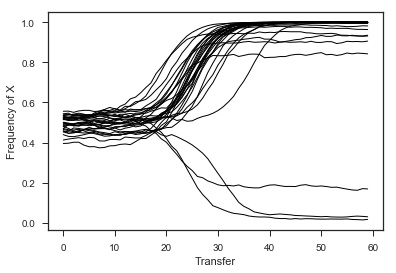

In [298]:
x = simulation(0.03, 10e-6, 1e-6, 1.2e4 * 10000, 60*13, 30)
y = x[:, :2, :].sum(axis=1)
plt.plot(y[::13], '-k', lw=1)
plt.ylabel('Frequency of X')
plt.xlabel('Transfer');

# Binomial test

In [382]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Beta Results                                 
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                 39.795
Model:                           Beta   AIC:                            -77.59
Method:            Maximum Likelihood   BIC:                            -76.19
Date:                Wed, 31 Jan 2018                                         
Time:                        13:21:22                                         
No. Observations:                  30                                         
Df Residuals:                      29                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0165      0.247      8.177      0.000       1.533       2.500
phi            1.4224      0.288      4.941      0.000       0.858       1.987
==============================================================================
"""

In [383]:
results.pvalues[0]

array([  2.90351816e-16,   7.76533832e-07])

In [303]:
def binomial(x, th = 0.5):    
    z = x[-1,:2].sum(axis=0)
    return scipy.stats.binom_test([(z > th).sum(), (z < 1-th).sum()], p=0.5, alternative='greater')

In [322]:
taus = np.linspace(1, 10)
xs = np.array([simulation(0.03, t*1e-6, 1e-6, 1.2e4 * 10000, 60*13, 30) for t in taus])

In [323]:
ths = np.linspace(0.5, 1.0)
rejection = np.array([[binomial(x, th) < 0.05 for x in xs] for th in ths])

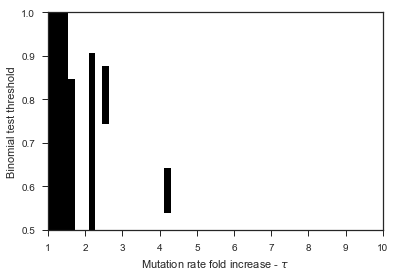

In [324]:
plt.pcolormesh(taus, ths, rejection, cmap=mpl.colors.ListedColormap(['k', 'w']))
# plt.colorbar(label='Binomial test p-value')
plt.xlabel(r'Mutation rate fold increase - $\tau$')
plt.ylabel(r'Binomial test threshold');

# Effective s 

In [375]:
import betareg

def intercept_to_s(intercept, t):
    return np.exp(intercept / t) - 1

In [378]:
Y = y[-1]
Y = (Y * (Y.size - 1) + 0.5) / Y.size
X = np.ones_like(Y)
beta_model = betareg.Beta(Y, X)
results = beta_model.fit()
coef = results.params[0]
print("Estimated s", intercept_to_s(coef, tmax))
print("Conf interval", [intercept_to_s(coef, tmax) 
                        for coef in results.conf_int()[0]])

Estimated s 0.00258856992819
Conf interval [0.0019675200648701097, 0.0032100047370544615]


In [377]:
results.summary()

                                 Beta Results                                 
Dep. Variable:                      y   Log-Likelihood:                 39.795
Model:                           Beta   AIC:                            -77.59
Method:            Maximum Likelihood   BIC:                            -76.19
Date:                Wed, 31 Jan 2018                                         
Time:                        12:51:59                                         
No. Observations:                  30                                         
Df Residuals:                      29                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0165      0.247      8.177      0.000       1.533       2.500
phi            1.4224      0.288      4.941      0.0

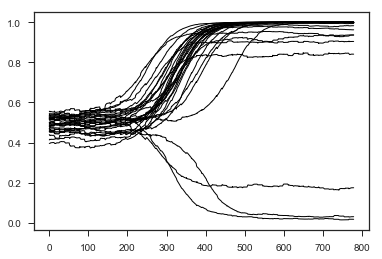

In [302]:
plt.plot(y, color='k', lw=1);

### Compare to 'regular' s

In [372]:
def simulation2(s, N, tmax, reps):
    N = int(N)
    x = np.zeros((tmax, reps))
    x[0, :] = np.random.beta(75, 75, reps) # random initial condition close to 1:1
    
    N_ = 100
    for t in range(1, tmax):
        # selection 
        x[t] = (1 + s) * x[t-1] / (1 + s * x[t-1])
        # drift
        N_ *= 2
        if N_ > N: N_ = 100
        x[t] = np.random.binomial(N_, x[t])/ N_
    return x

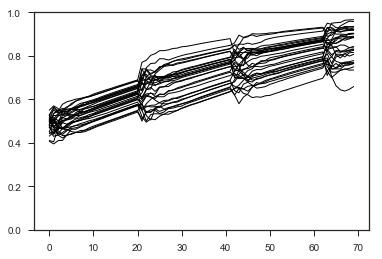

In [301]:
x2 = simulation2(s=0.03, N=N, 7*10, 30)
plt.plot(x2, color='k', lw=1)
plt.ylim(0, 1);

In [289]:
Y = x2[-1]
Y = (Y * (Y.size - 1) + 0.5) / Y.size
X = np.ones_like(Y)
beta_model = betareg.Beta(Y, X)
results = beta_model.fit()
# print(results.summary())
coef = results.params[0]
print("Estimated s", intercept_to_s(coef, 7*10))
print("Conf interval", [intercept_to_s(coef, 7*10) for coef in results.conf_int()[0]])

Estimated s 0.0301842532066
Conf interval [0.027889984118788735, 0.032483643144533003]


## Approach robustness

In [338]:
rejection = []
for x in xs:
    y = x[:, :2, :].sum(axis=1)
    Y = y[-1]
    Y = (Y * (Y.size - 1) + 0.5) / Y.size
    X = np.ones_like(Y)
    beta_model = betareg.Beta(Y, X)
    results = beta_model.fit()
    rejection.append((results.conf_int()[0] > 0).all())

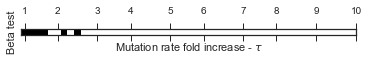

In [371]:
fig, ax = plt.subplots(figsize=(6,3))
ax.matshow([rejection], origin=(0,0), cmap=mpl.colors.ListedColormap(['k', 'w']))
ax.set(
    ylabel=('Beta test'),
    xlabel=(r'Mutation rate fold increase - $\tau$'),
    xticks=np.linspace(0, len(taus), 10, dtype=int),
    xticklabels=np.linspace(taus.min(), taus.max(), 10, dtype=int),
    yticks=[],
);

# ABC: mutator model

Process:

$$
p_0 = 1/2 \\
t_1 \sim Geom(u_1 N p_0 2 s) \\
t_2 \sim Geom(u_2 N (1-p_0) 2 s) \\
p_t = \frac{p_0}{p_0 + (1-p_0) (1-s)^{t_1 - t_2}}
$$

### Simulations

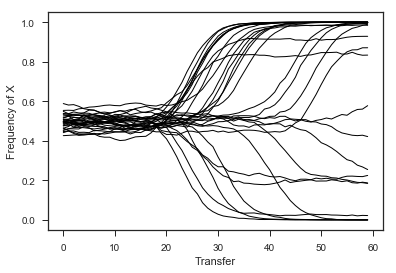

In [96]:
s, u1, u2 = 0.03, 3e-6, 1e-6
N = 1.2e4 * 10000
tmax = 60*13
reps = 30
x = simulation(s, u1, u2, N, tmax, reps)
y = x[:, :2, :].sum(axis=1)
plt.plot(y[::13], '-k', lw=1)
plt.ylabel('Frequency of X')
plt.xlabel('Transfer');

In [153]:
def approx_simulation(s, N, p0, u1, u2, tmax, reps):
    t1 = np.minimum(tmax, np.random.geometric(u1 * N * p0 * 2 * s, reps))
    t2 = np.minimum(tmax, np.random.geometric(u2 * N * (1-p0) * 2 * s, reps))
    pt = p0 / (p0 + (1-p0) / (1+s)**(t2 - t1))
    return pt

Ne = int(scipy.stats.hmean([int(N/10000 * 2**(t % 13)) for t in range(13)]))

In [87]:
%timeit [approx_simulation(s, Ne, 0.5, u1, u2, tmax, 1).ravel() for _ in range(1000)]
%timeit approx_simulation(s, Ne, 0.5, u1, u2, tmax, 1000)

13.2 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
104 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [154]:
n_approx = 10000
approx_hist, bins = np.histogram(approx_simulation(s, Ne, 0.5, u1, u2, tmax, n_approx), bins=np.linspace(0, 1, 21), density=True)
sims_hist, bins_ = np.histogram(y[-1], bins=np.linspace(0, 1, 21), density=True)
assert np.allclose(bins, bins_)

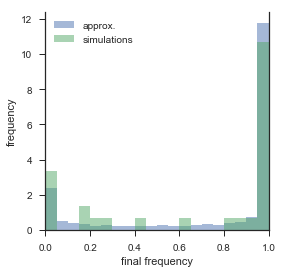

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)
ax.bar(bins[:-1], approx_hist, align='edge', alpha=0.5, width=0.05, label='approx.')
ax.bar(bins[:-1], sims_hist, align='edge', alpha=0.5, width=0.05, label='simulations')
ax.set(xlim=(0, 1), xlabel='final frequency', ylabel='frequency')
ax.legend()
sns.despine(right=False)

In [156]:
scipy.stats.entropy(sims_hist, approx_hist)

0.26637986573461836

In [157]:
def abc(data_hist, data_bins, Ne, tmax, p0=0.5, n_params=1000, n_approx=1000, λ=0.5):
    ss = 10**(np.random.uniform(-4, 0, n_params))
    u1s = 10**(np.random.uniform(-4, 0, n_params))/Ne
    u2s = 10**(np.random.uniform(-4, 0, n_params))/Ne
    results = [None] * n_params
    for i, (s, u1, u2) in enumerate(zip(ss, u1s, u2s)):
        approx = approx_simulation(s, Ne, p0, u1, u2, tmax, n_approx)
        approx_hist, _ = np.histogram(approx, bins=data_bins)
        approx_hist = approx_hist + λ
        approx_hist /= approx_hist.sum()
        score = scipy.stats.entropy(data_hist, approx_hist)
        assert np.isfinite(score)
        results[i] = dict(kl=score, s=s, u1=u1, u2=u2, Ne=Ne, p0=p0, tmax=tmax)
    return pd.DataFrame(results)

In [158]:
sims_hist, sims_bins = np.histogram(y[-1], bins=np.linspace(0, 1, 11), density=True)
df = abc(sims_hist, sims_bins, Ne, tmax, p0=0.5, n_params=10000, n_approx=1000)
df.head()

,Ne,kl,p0,s,tmax,u1,u2
0,78009,2.329295,0.5,0.036599,780,1.621030e-08,1.684440e-07
1,78009,6.143808,0.5,0.001021,780,9.038240e-08,1.817678e-08
2,78009,2.672436,0.5,0.014389,780,1.078575e-07,8.107635e-09
3,78009,0.656751,0.5,0.014016,780,8.758790e-07,1.858118e-06
4,78009,6.015470,0.5,0.001613,780,1.048165e-06,1.756017e-08


In [159]:
best_etimates = df.sort_values('kl')[:100]
best_row = df[df['kl']==df['kl'].min()]
print("kl ratio:", best_etimates['kl'].max()/best_etimates['kl'].min())
print('s', s, best_row['s'].values, best_etimates['s'].min(), best_etimates['s'].max())
print('u1', u1, best_row['u1'].values, best_etimates['u1'].min(), best_etimates['u1'].max())
print('u2', u2, best_row['u2'].values, best_etimates['u2'].min(), best_etimates['u2'].max())

kl ratio: 2.17066680992
s 0.03 [ 0.01989066] 0.0102768087328 0.450370417052
u1 3e-06 [  2.73701685e-06] 7.06302784476e-07 6.50720879649e-06
u2 1e-06 [  9.68272049e-07] 3.36488633468e-07 3.1011145827e-06


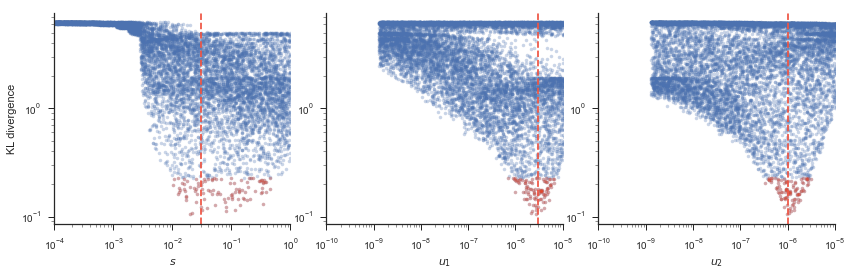

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
plot_kws = dict(
    marker = '.',
    ls='',
    alpha = 0.3
)

ax = axes[0]
ax.plot(df['s'], df['kl'], **plot_kws)
ax.plot(best_etimates['s'], best_etimates['kl'], **plot_kws, color='#ee4422')
ax.axvline(s, color='#ee5544', ls='--')
ax.set(xlabel='$s$', ylabel='KL divergence', yscale='log', xscale='log', xlim=(1e-4, 1))
ax = axes[1]
ax.plot(df['u1'], df['kl'], **plot_kws)
ax.plot(best_etimates['u1'], best_etimates['kl'], **plot_kws, color='#ee4422')
ax.set(xlabel='$u_1$', xscale='log', yscale='log', xlim=(1e-10, 1e-5))
ax.axvline(u1, color='#ee5544', ls='--')
ax = axes[2]
ax.plot(df['u2'], df['kl'], **plot_kws)
ax.plot(best_etimates['u2'], best_etimates['kl'], **plot_kws, color='#ee4422')
ax.axvline(u2, color='#ee5544', ls='--')
ax.set(xlabel='$u_2$', xscale='log', yscale='log', xlim=(1e-10, 1e-5))

fig.tight_layout()
sns.despine()